<a href="https://colab.research.google.com/github/JoeJiraWat/Ai-Builders/blob/main/Ai_files/plotNote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import collections


In [ ]:
def load_audio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        return y, sr
    except Exception as e:
        print(f"Error loading audio file '{file_path}': {e}")
        return None, None


In [ ]:
def extract_pitch(y, sr, hop_length=512, fmin_note='C2', fmax_note='C7'):
    f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                 fmin=librosa.note_to_hz(fmin_note),
                                                 fmax=librosa.note_to_hz(fmax_note),
                                                 hop_length=hop_length)
    return f0, voiced_flag, hop_length


In [ ]:
def f0_to_notes(f0_contour):
    notes = []
    for f_val in f0_contour:
        if f_val is not None and f_val > 0 and not np.isnan(f_val):
            try:
                note_name = librosa.hz_to_note(f_val)
                notes.append(note_name)
            except Exception:
                pass
    return notes


In [ ]:
def plot_note_distribution_en(notes, audio_filename, figure_number=1):
    if not notes:
        print(f"No note data found for file: {audio_filename}")
        return

    note_counts = collections.Counter(notes)
    parsed_notes_for_sorting = []
    for note, count in note_counts.items():
        try:
            octave_str = ''.join(filter(str.isdigit, note))
            if not octave_str:
                octave = 0
                note_base_name = note
            else:
                octave = int(octave_str)
                note_base_name = note.replace(octave_str, '', 1)
            note_map = {'C':0, 'C#':1, 'D♭':1, 'D':2, 'D#':3, 'E♭':3, 'E':4, 'F':5,
                        'F#':6, 'G♭':6, 'G':7, 'G#':8, 'A♭':8, 'A':9, 'A#':10, 'B♭':10, 'B':11}
            pitch_class_value = note_map.get(note_base_name, -1)
            if pitch_class_value != -1:
                parsed_notes_for_sorting.append({'name': note, 'octave': octave, 'base': note_base_name, 'count': count})
            else:
                parsed_notes_for_sorting.append({'name': note, 'octave': 0, 'base': note, 'count': count})
        except Exception:
            parsed_notes_for_sorting.append({'name': note, 'octave': 0, 'base': note, 'count': count})

    def get_sort_key(item):
        note_order = {'C':0, 'C#':1, 'D♭':1, 'D':2, 'D#':3, 'E♭':3, 'E':4, 'F':5,
                      'F#':6, 'G♭':6, 'G':7, 'G#':8, 'A♭':8, 'A':9, 'A#':10, 'B♭':10, 'B':11}
        return (item['octave'], note_order.get(item['base'], 99), item['name'])

    parsed_notes_for_sorting.sort(key=get_sort_key)
    unique_notes_sorted = [item['name'] for item in parsed_notes_for_sorting]
    counts_sorted = [item['count'] for item in parsed_notes_for_sorting]

    dominant_note = "N/A"
    if note_counts:
        dominant_note = note_counts.most_common(1)[0][0]

    # สร้าง Figure ใหม่สำหรับแต่ละกราฟ
    plt.figure(figure_number, figsize=(18, 9))
    plt.clf() # Clear the current figure in case it was used before

    bars = plt.bar(unique_notes_sorted, counts_sorted, color='cornflowerblue')
    plt.xlabel("Musical Notes (Sorted by Pitch)", fontsize=12)
    plt.ylabel("Frequency of Occurrence", fontsize=12)
    plt.title(f"Note Distribution in File: {audio_filename}\n(Most Frequent Note (Approx. Key): {dominant_note})", fontsize=14)
    plt.xticks(rotation=70, ha="right", fontsize=9)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    max_count = max(counts_sorted) if counts_sorted else 1
    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02 * max_count,
                     int(yval), ha='center', va='bottom', fontsize=8, color='dimgray')

    plt.tight_layout()


In [ ]:
def get_wav_file_path(prompt_message):
    """รับ Path ของไฟล์เสียง .wav จากผู้ใช้ และตรวจสอบ"""
    while True:
        file_path_input = input(prompt_message).strip()
        if file_path_input.lower() == 'skip': # เพิ่มตัวเลือก skip
            return None
        if file_path_input.startswith('"') and file_path_input.endswith('"'):
            file_path_input = file_path_input[1:-1]
        if not file_path_input.lower().endswith(".wav"):
            print("Error: Please select a .wav file only.")
            continue
        if not os.path.exists(file_path_input):
            print(f"Error: File not found at '{file_path_input}'")
            continue
        return file_path_input


In [ ]:
def process_and_plot_single_file(file_path, figure_number):
    """โหลด วิเคราะห์ และพล็อตไฟล์เสียงเดียว"""
    if file_path is None:
        print(f"Skipping plot for figure {figure_number}.")
        return

    print(f"\nAnalyzing file: {file_path}")
    y, sr = load_audio(file_path)

    if y is None:
        return

    f0, _, _ = extract_pitch(y, sr)

    if f0 is None or not np.any(f0[~np.isnan(f0) & (f0 > 0)]):
        print("Could not extract pitch from this audio file.")
        return

    notes_in_audio = f0_to_notes(f0)

    if not notes_in_audio:
        print("No distinct notes found in this audio file.")
        return

    audio_filename = os.path.basename(file_path)
    plot_note_distribution_en(notes_in_audio, audio_filename, figure_number=figure_number)


--- Audio File Note Analyzer (Plotting Two Files) ---
Enter path for the FIRST .wav file (or type 'skip'): /content/drive/MyDrive/Datasets_For_Ai_builders/test/First [vocals].wav
Enter path for the SECOND .wav file (or type 'skip'): /content/drive/MyDrive/Datasets_For_Ai_builders/output/First [vocals]_corrected_final.wav

Analyzing file: /content/drive/MyDrive/Datasets_For_Ai_builders/test/First [vocals].wav

Analyzing file: /content/drive/MyDrive/Datasets_For_Ai_builders/output/First [vocals]_corrected_final.wav

Displaying plots (if any)...


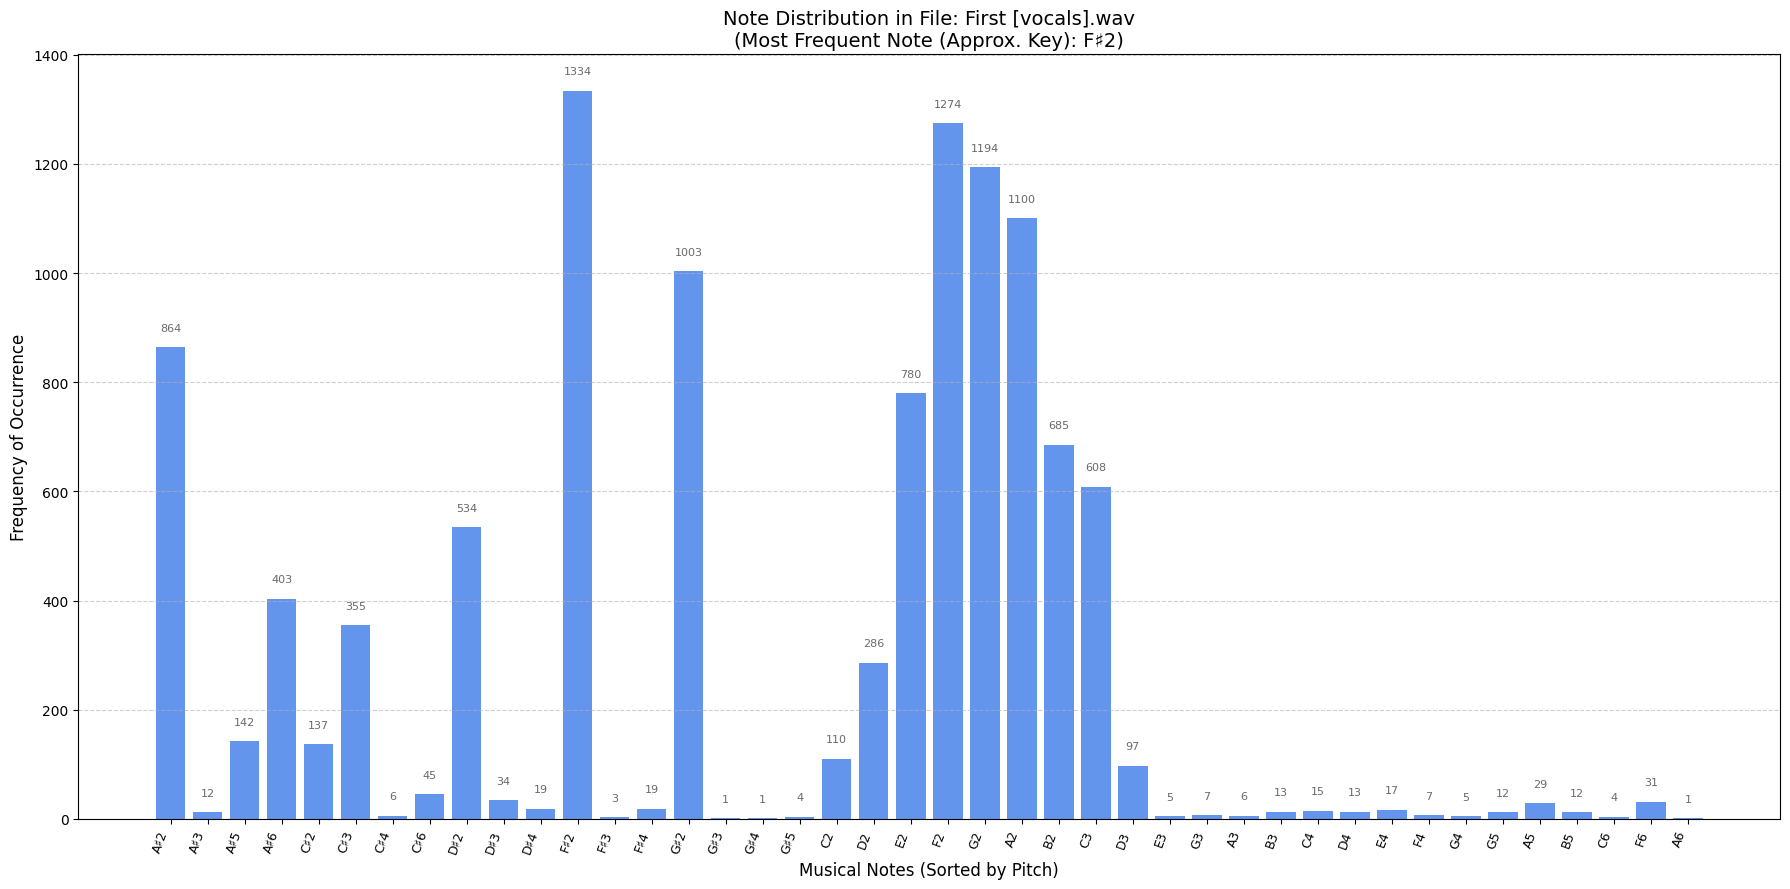

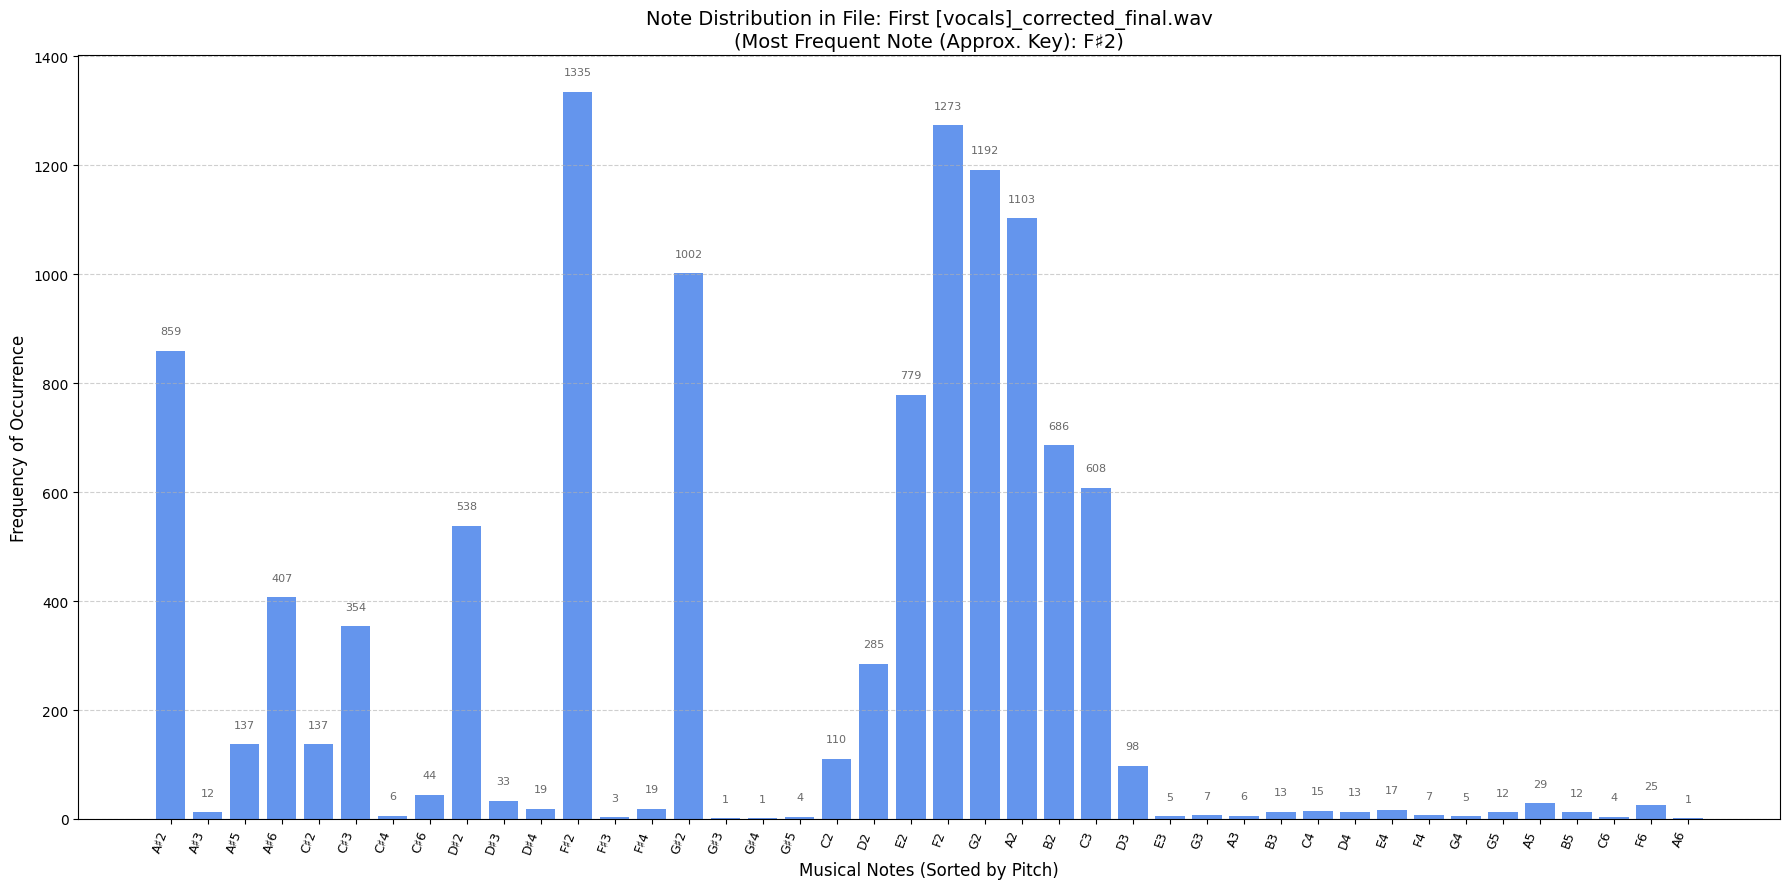


--- Analysis complete ---


In [ ]:
if __name__ == "__main__":
    print("--- Audio File Note Analyzer (Plotting Two Files) ---")

    file_path1 = get_wav_file_path("Enter path for the FIRST .wav file (or type 'skip'): ")
    file_path2 = get_wav_file_path("Enter path for the SECOND .wav file (or type 'skip'): ")

    if file_path1:
        process_and_plot_single_file(file_path1, figure_number=1)
    if file_path2:
        process_and_plot_single_file(file_path2, figure_number=2)

    if file_path1 or file_path2:
         if not ('%matplotlib inline' in str(get_ipython().config['IPKernelApp']['matplotlib']) if 'get_ipython' in globals() else False):
            print("\nDisplaying plots (if any)...")
            plt.show()


    print("\n--- Analysis complete ---")
